In [1]:
#import os
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
import jax
import juniper as jp

from juniper.Gaussian import Gaussian
from juniper.LateralKernel import LateralKernel

from juniper.steps.NeuralField import NeuralField
from juniper.steps.StaticGain import StaticGain
from juniper.steps.DemoInput import DemoInput
from juniper.steps.TimedBoost import TimedBoost


from demo.demo_huetchen import demo_huetchen

In [2]:
print("Computing devices found by JAX:")
print(jax.local_devices())

Computing devices found by JAX:
[CpuDevice(id=0)]


In [3]:
arch = jp.Architecture.get_arch()

<img src="demo/img/demo4_sketch.png" alt="demo sketch" width="400">

In [4]:
jp.Architecture.delete_arch()
arch = jp.Architecture.get_arch()
shape = (294,447)

# Static steps
demo_input = DemoInput("in0", {"shape":shape, "sigma":(30,30), "amplitude":0, "center": (0,0)})
boost_input = TimedBoost("boost", {"amplitude":3, "duration": [1.6, 4]})
st0 = StaticGain("st0", {"factor": 6})
st1 = StaticGain("st1", {"factor": 2})

# field params
exc_mem_kernel = Gaussian({"sigma": (30,30), "amplitude": 300, "normalized": True})
inh_mem_kernel = Gaussian({"sigma": (55,55), "amplitude": -10, "normalized": True})
memory_kernel = LateralKernel({"kernels": [exc_mem_kernel, inh_mem_kernel], "wheights": [0.5, 0.5]})
exc_kernel = Gaussian({"sigma": (30,30), "amplitude": 10, "normalized": True})
inh_kernel = Gaussian({"sigma": (55,55), "amplitude": -3, "normalized": True})
nf_kernel = LateralKernel({"kernels": [exc_kernel, inh_kernel], "wheights": [0.5,0.5]})

# Dynamic steps
nf0 = NeuralField("Memory Field", {"shape": shape, "resting_level": -5, "global_inhibition": -0.01, "tau": 0.05,  "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "lateral_kernel_convolution": memory_kernel})
nf1 = NeuralField("Action Field", {"shape": shape, "resting_level": -5, "global_inhibition": -0.00, "tau": 0.02,  "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "lateral_kernel_convolution": nf_kernel})
nf2 = NeuralField("Attention Field", {"shape": shape, "resting_level": -5, "global_inhibition": -0.00, "tau": 0.05,  "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "lateral_kernel_convolution": nf_kernel})

# connections
demo_input >> nf2 >> st0 >> nf0 >> st1 >> nf1
boost_input >> nf1

arch.compile()

Loading saved buffers...


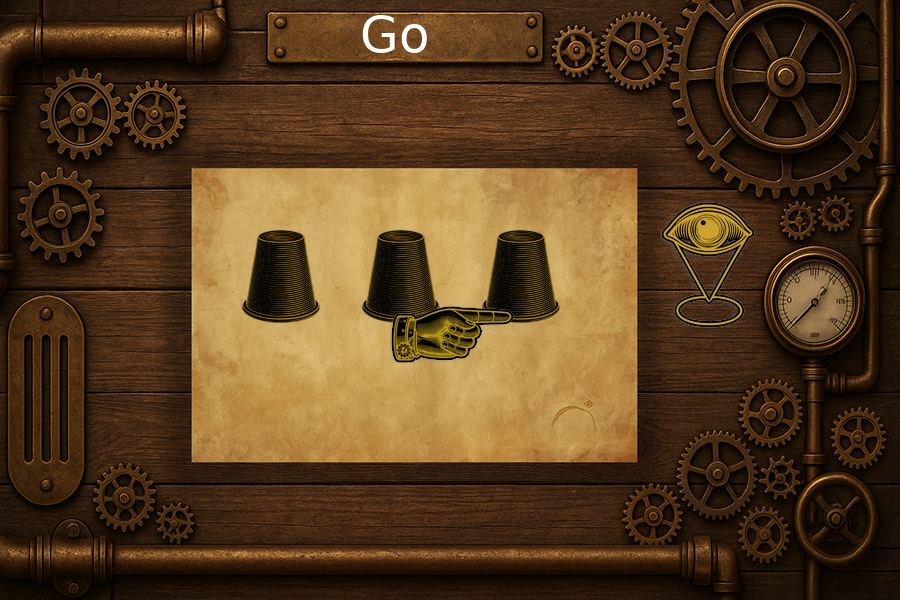

In [5]:
num_steps = 150
demo = demo_huetchen(arch, eye_field="Attention Field", hand_field="Action Field")
recording = demo.run(num_steps)

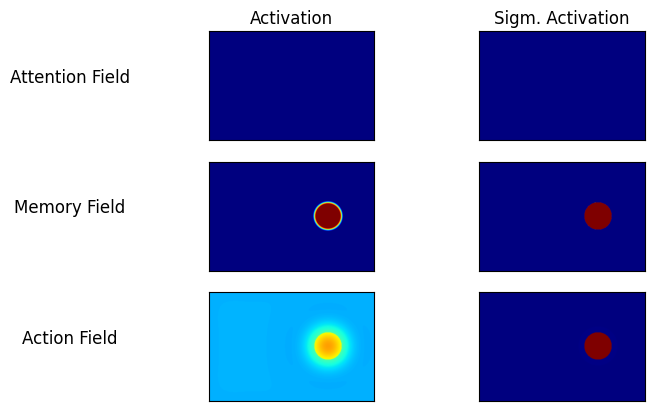

In [6]:
demo.plot()